In [134]:
import random
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, explained_variance_score
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter1d
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

from side_info_decoding.utils import set_seed, load_data_from_pids
from density_decoding.decoders.behavior_decoder import generic_decoder, sliding_window_decoder

seed = 666
set_seed(seed)

In [2]:
class GLM(torch.nn.Module):    
    def __init__(self, n_c, n_t, n_r):
        super(GLM, self).__init__()
        self.U = torch.nn.Parameter(torch.randn(n_c, n_r))
        self.V = torch.nn.Parameter(torch.randn(n_r, n_t))
        self.b = torch.nn.Parameter(torch.randn(1, n_c, 1))
        
    def forward(self, y):
        self.beta = torch.einsum("cr,rt->ct", self.U, self.V)
        x_pred = self.beta[None,:,:] * y + self.b
        return x_pred
    
def train_glm(
    X, 
    Y, 
    train,
    test,
    n_r = 2,
    learning_rate=1e-3,
    n_epochs=10000,
    ):
    
    _, n_c, n_t = X.shape
    glm = GLM(n_c, n_t, n_r)
    optimizer = torch.optim.Adam(glm.parameters(), lr=learning_rate)
    criterion = torch.nn.PoissonNLLLoss(full=True)
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)[:,None,:]
    train_x, test_x = X[train], X[test]
    train_y, test_y = Y[train], Y[test]
    
    losses = []
    for epoch in tqdm(range(n_epochs), desc="Train GLM:"):
        optimizer.zero_grad()
        x_pred = glm(train_y)
        loss = criterion(x_pred, train_x)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return glm, losses

In [3]:
pids = [
    "dab512bd-a02d-4c1f-8dbc-9155a163efc0",
]

In [208]:
X_dict, Y_dict = load_data_from_pids(
    pids,
    brain_region="lp",
    behavior="motion_energy",
    data_type="all_ks",
    n_t_bins = 50,
    t_before = .2,
    t_after = .8,
    normalize_input=False
)

pulling data from ibl database ..
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
number of trials found: 367 (active: 367)
prior for this session is not found.
found 367 trials from 17.56 to 2310.24 sec.
found 131 Kilosort units in region lp


Compute spike count: 100%|██████████████████| 367/367 [00:00<00:00, 1639.25it/s]


In [209]:
pid = pids[0]
X, Y = X_dict[pid], Y_dict[pid]
smooth_Y = np.array([gaussian_filter1d(Y[k, :], 4) for k in range(K)])
norm_Y = normalize(smooth_Y)
K, C, T = X.shape
print(X.shape)
print(Y.shape)

(367, 126, 50)
(367, 50)


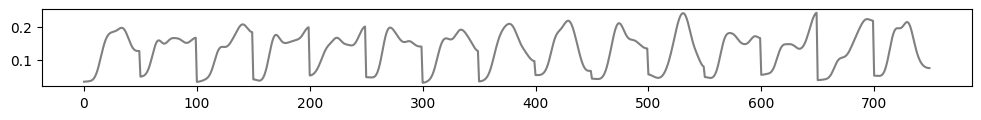

In [210]:
plt.figure(figsize=(12,1))
plt.plot(norm_Y[10:10+15].flatten(), c="gray");

In [179]:
trial_idxs = np.arange(K)
random.shuffle(trial_idxs)
train, test = train_test_split(trial_idxs, test_size=0.1)

In [206]:
def time_bin_wise_metrics(y_true, y_pred):
    r2 = r2_score(y_true.flatten(), y_pred.flatten())
    corr = pearsonr(y_true.flatten(), y_pred.flatten())[0]
    return r2, corr

def trial_wise_metrics(y_true, y_pred):
    r2 = np.mean([r2_score(y_true[k], y_pred[k]) for k in range(len(y_true))])
    corr = np.mean([pearsonr(y_true[k], y_pred[k])[0] for k in range(len(y_true))])
    return r2, corr

In [190]:
def continuous_decoder(train_X, train_Y, test_X, test_Y, time_independent=False):
    penalty = [0.01, 1, 10, 100]
    
    train_K, test_K = len(train_X), len(test_X)
    _, C, T = train_X.shape
    if time_independent:
        train_X = np.moveaxis(train_X, 1, -1).reshape((-1, C))
        test_X = np.moveaxis(test_X, 1, -1).reshape((-1, C))
        train_Y = train_Y.reshape((-1))
        test_Y = test_Y.reshape((-1))
        print("time-independent:")
    else:
        train_X = np.moveaxis(train_X, 1, -1).reshape((-1, T*C))
        test_X = np.moveaxis(test_X, 1, -1).reshape((-1, T*C))
        print("time-dependent:")
    
    decoder = GridSearchCV(Ridge(), {"alpha": penalty})
    decoder.fit(train_X, train_Y)
    print(decoder.best_params_)
    pred_Y = decoder.predict(test_X)
    test_Y = test_Y.reshape(test_K, T)
    pred_Y = pred_Y.reshape(test_K, T)
    
    if time_independent:
        r2, corr = time_bin_wise_metrics(test_Y, pred_Y)
    else:
        r2, corr = trial_wise_metrics(test_Y, pred_Y)
    print(f"r2: {r2:.3f} corr: {corr:.3f}")
    
    return pred_Y, [r2, corr]

In [27]:
def sliding_window_over_time(data, half_window_size=3):
    
    window_size = 2*half_window_size + 1
    
    if len(data.shape) == 3:
        n_trials, n_units, n_t_bins = data.shape
        data_window = np.zeros((
            n_trials, n_units, n_t_bins - 2*half_window_size, window_size
        ))
        for t in range(n_t_bins - 2*half_window_size):
            tmp_window = np.zeros((n_trials, n_units, window_size))
            for d in range(window_size):
                  tmp_window[:,:,d] = data[:,:,t + d]
            data_window[:,:,t] = tmp_window
    else:
        n_trials, n_t_bins = data.shape
        max_len = n_t_bins - 2*half_window_size
        data_window = np.zeros((n_trials, max_len, window_size))
        for t in range(max_len):
            data_window[:,t] = data[:,t:t+window_size]
        data_window = data_window[:,:,half_window_size]
    return data_window

In [192]:
def sliding_window_decoder(train_X, train_Y, test_X, test_Y):
    penalty = [0.01, 1, 10, 100]
    
    train_K, C, T, L = train_X.shape
    test_K, _, _, _ = test_X.shape
    
    train_X = train_X.transpose(0,1,-1,2).reshape(train_K, C*L, T).transpose(0,-1,1).reshape((-1, C*L))
    test_X = test_X.transpose(0,1,-1,2).reshape(test_K, C*L, T).transpose(0,-1,1).reshape((-1, C*L))
    train_Y = train_Y.reshape((-1))
    test_Y = test_Y.reshape((-1))
    
    decoder = GridSearchCV(Ridge(), {"alpha": penalty})
    decoder.fit(train_X, train_Y)
    print(decoder.best_params_)
    pred_Y = decoder.predict(test_X)
    test_Y = test_Y.reshape(test_K, T)
    pred_Y = pred_Y.reshape(test_K, T)
    
    r2, corr = time_bin_wise_metrics(test_Y, pred_Y)
    print("sliding-window:")
    print(f"r2: {r2:.3f} corr: {corr:.3f}")
    
    return pred_Y, [r2, corr]

#### simple smoothing

In [193]:
smooth_X = np.array(
    [[gaussian_filter1d(X[k, c, :], 4) for c in range(C)] for k in range(K)]
)

train_X, test_X = smooth_X[train], smooth_X[test]
train_Y, test_Y = norm_Y[train], norm_Y[test]

y_pred, _ = continuous_decoder(train_X, train_Y, test_X, test_Y, time_independent=True)
y_pred, _ = continuous_decoder(train_X, train_Y, test_X, test_Y, time_independent=False)

time-independent:
{'alpha': 100}
r2: 0.623 corr: 0.797
time-dependent:
{'alpha': 100}
r2: 0.760 corr: 0.908


In [202]:
window_X = sliding_window_over_time(smooth_X, half_window_size=3)
window_Y = sliding_window_over_time(norm_Y, half_window_size=3)
train_X, test_X = window_X[train], window_X[test]
train_Y, test_Y = window_Y[train], window_Y[test]
print(window_X.shape)

y_pred, _ = sliding_window_decoder(train_X, train_Y, test_X, test_Y)

(367, 159, 44, 7)
{'alpha': 100}
sliding-window:
r2: 0.636 corr: 0.803


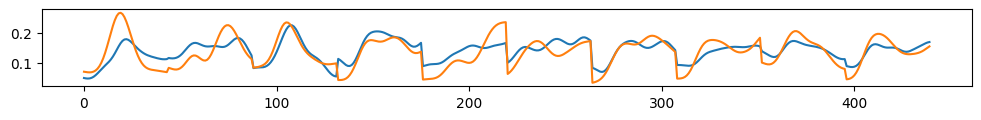

In [203]:
plt.figure(figsize=(12,1))
plt.plot(y_pred[:10].flatten());
plt.plot(test_Y[:10].flatten());

#### GLM

In [88]:
R = 20

glm, losses = train_glm(
    X = smooth_X,
    Y = norm_Y, 
    train = train,
    test = test,
    n_r = R,
    learning_rate = 5e-3,
    n_epochs = 5000
)

Train GLM:: 100%|███████████████████████████| 5000/5000 [04:02<00:00, 20.61it/s]


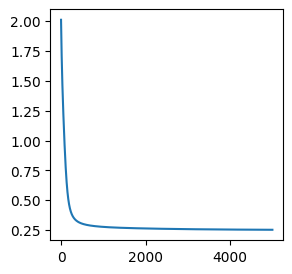

In [89]:
plt.figure(figsize=(3,3))
plt.plot(losses);

#### decode supervised latents from GLM

In [90]:
supervised_subspace = glm.U.detach().numpy()
subspace_weights = glm.V.detach().numpy()

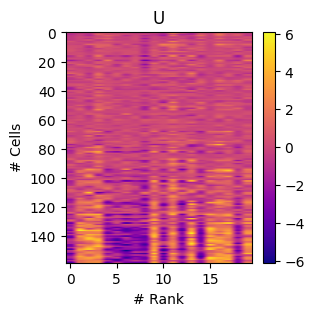

In [91]:
plt.figure(figsize=(3,3))
plt.imshow(supervised_subspace, aspect="auto", cmap="plasma")
plt.title("U")
plt.xlabel("# Rank")
plt.ylabel("# Cells")
plt.colorbar()
plt.show()

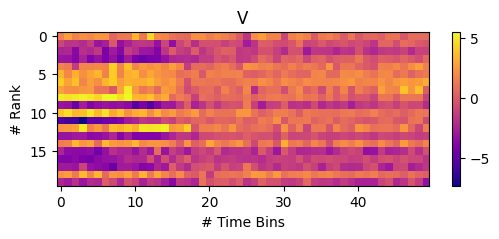

In [92]:
plt.figure(figsize=(6,2))
plt.imshow(subspace_weights, aspect="auto", cmap="plasma")
plt.title("V")
plt.xlabel("# Time Bins")
plt.ylabel("# Rank")
plt.colorbar()
plt.show()

In [93]:
all_proj = smooth_X.transpose(0,-1,1) @ supervised_subspace
weighted_proj = all_proj * subspace_weights.T
smooth_proj = np.array(
    [[gaussian_filter1d(weighted_proj[k, :, r], 4) for r in range(R)] for k in range(K)]
)
print(smooth_proj.shape)

(367, 20, 50)


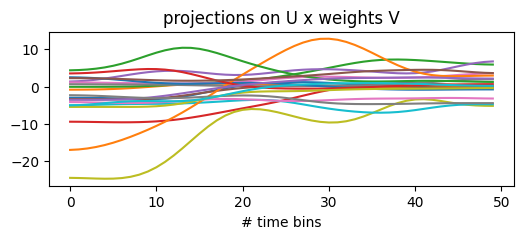

In [94]:
plt.figure(figsize=(6,2))
plt.plot(smooth_proj.mean(0).T)
plt.title("projections on U x weights V")
plt.xlabel("# time bins")
plt.show()

In [ ]:
train_X, test_X = smooth_proj[train], smooth_proj[test]
train_Y, test_Y = norm_Y[train], norm_Y[test]

_, _ = continuous_decoder(train_X, train_Y, test_X, test_Y, time_independent=True)
_, _ = continuous_decoder(train_X, train_Y, test_X, test_Y, time_independent=False)

In [ ]:
window_X = sliding_window_over_time(smooth_proj, half_window_size=5)
window_Y = sliding_window_over_time(norm_Y, half_window_size=5)
train_X, test_X = window_X[train], window_X[test]
train_Y, test_Y = window_Y[train], window_Y[test]
print(window_X.shape)

_, _ = sliding_window_decoder(train_X, train_Y, test_X, test_Y)

#### decode reconstructed firing rates from GLM

In [100]:
train_X, test_X = smooth_X[train], smooth_X[test]
train_Y, test_Y = norm_Y[train], norm_Y[test]

pred_Y, _ = continuous_decoder(train_X, train_Y, smooth_X, norm_Y, time_independent=False)

time-dependent:
r2: 0.500 corr: 0.731


In [101]:
inferred_rates = glm(torch.tensor(pred_Y)[:,None,:]).exp().detach().numpy()
smooth_rates = np.array(
    [[gaussian_filter1d(inferred_rates[k, c, :], 4) for c in range(C)] for k in range(K)]
)

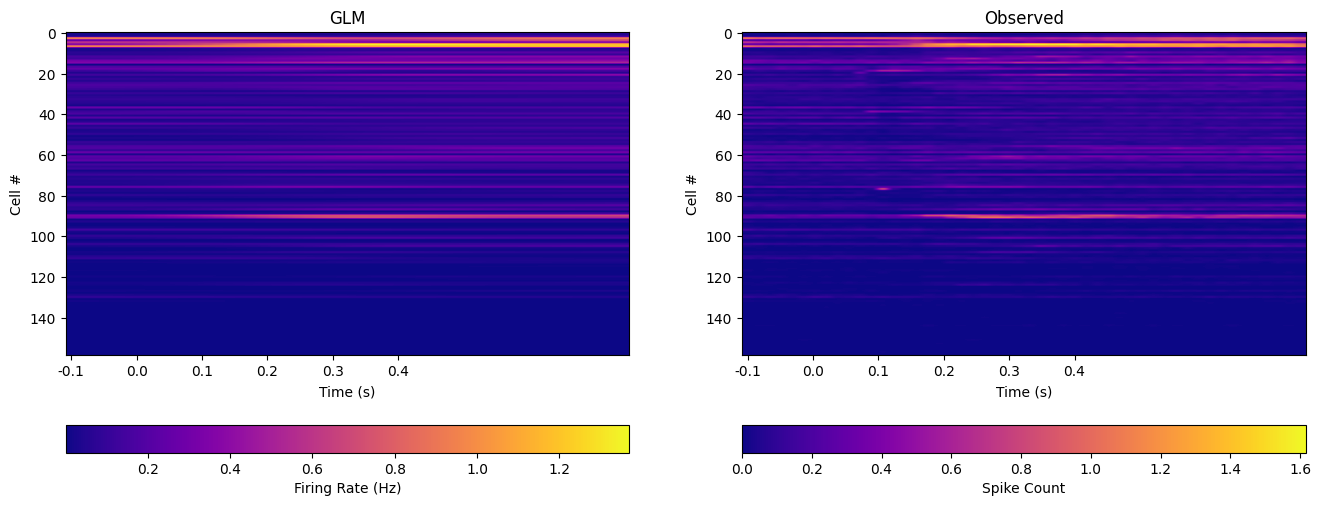

In [102]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))
im1 = ax1.imshow(smooth_rates.mean(0), aspect="auto", cmap=plt.cm.plasma)
ax1.set_xticks(np.linspace(0, 29, 6), ['%.1f'%i for i in np.linspace(-.1, .4, 6)])
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Cell #')
cbar = plt.colorbar(im1, ax=ax1, orientation='horizontal', label='Firing Rate (Hz)')
ax1.set_title('GLM')

im2 = ax2.imshow(X.mean(0), aspect="auto", cmap=plt.cm.plasma)
ax2.set_xticks(np.linspace(0, 29, 6), ['%.1f'%i for i in np.linspace(-.1, .4, 6)])
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Cell #')
cbar = plt.colorbar(im2, ax=ax2, orientation='horizontal', label='Spike Count')
ax2.set_title('Observed');

In [ ]:
train_X, test_X = smooth_rates[train], smooth_rates[test]
train_Y, test_Y = norm_Y[train], norm_Y[test]

_, _ = continuous_decoder(train_X, train_Y, test_X, test_Y, time_independent=True)
_, _ = continuous_decoder(train_X, train_Y, test_X, test_Y, time_independent=False)

In [ ]:
window_X = sliding_window_over_time(smooth_rates, half_window_size=5)
window_Y = sliding_window_over_time(norm_Y, half_window_size=5)
train_X, test_X = window_X[train], window_X[test]
train_Y, test_Y = window_Y[train], window_Y[test]
print(window_X.shape)

_, _ = sliding_window_decoder(train_X, train_Y, test_X, test_Y)

#### cross validation

simple smoothing

In [211]:
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

K, C, T = X.shape
smooth_X = np.array(
    [[gaussian_filter1d(X[k, c, :], 4) for c in range(C)] for k in range(K)]
) # (K, C, T)

obs_lst, pred_lst, r2_tbin, r2_trial = [], [], [], []
for fold_idx, (train, test) in enumerate(kf.split(smooth_X)):
    train_X, test_X = smooth_X[train], smooth_X[test]
    train_Y, test_Y = norm_Y[train], norm_Y[test]

    _, _ = continuous_decoder(train_X, train_Y, test_X, test_Y, time_independent=True)
    _, metrics = continuous_decoder(train_X, train_Y, test_X, test_Y, time_independent=False)
    r2_trial.append(metrics[0])
    
    window_X = sliding_window_over_time(smooth_X, half_window_size=5)
    window_Y = sliding_window_over_time(norm_Y, half_window_size=5)
    train_X, test_X = window_X[train], window_X[test]
    train_Y, test_Y = window_Y[train], window_Y[test]
    _, metrics = sliding_window_decoder(train_X, train_Y, test_X, test_Y)
    r2_tbin.append(metrics[0])
    
print("smoothing:")
print(f"time-independent r2: {np.mean(r2_tbin)} trial-wise r2: {np.mean(r2_trial)}")

time-independent:
{'alpha': 100}
r2: 0.589 corr: 0.768
time-dependent:
{'alpha': 100}
r2: 0.767 corr: 0.916
{'alpha': 100}
sliding-window:
r2: 0.648 corr: 0.805
time-independent:
{'alpha': 100}
r2: 0.585 corr: 0.765
time-dependent:
{'alpha': 100}
r2: -0.256 corr: 0.816
{'alpha': 100}
sliding-window:
r2: 0.638 corr: 0.800
time-independent:
{'alpha': 100}
r2: 0.604 corr: 0.779
time-dependent:
{'alpha': 100}
r2: -0.340 corr: 0.866
{'alpha': 100}
sliding-window:
r2: 0.682 corr: 0.827
time-independent:
{'alpha': 100}
r2: 0.627 corr: 0.794
time-dependent:
{'alpha': 100}
r2: 0.562 corr: 0.890
{'alpha': 100}
sliding-window:
r2: 0.654 corr: 0.810
time-independent:
{'alpha': 100}
r2: 0.658 corr: 0.815
time-dependent:
{'alpha': 100}
r2: -0.613 corr: 0.912
{'alpha': 100}
sliding-window:
r2: 0.681 corr: 0.826
smoothing:
time-independent r2: 0.6606059274472702 trial-wise r2: 0.02399552962826761


reduced-rank GLM

Train GLM:: 100%|███████████████████████████| 5000/5000 [03:31<00:00, 23.60it/s]


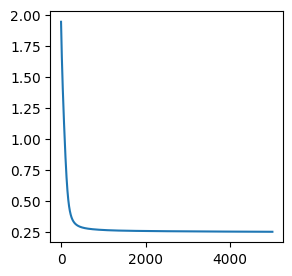

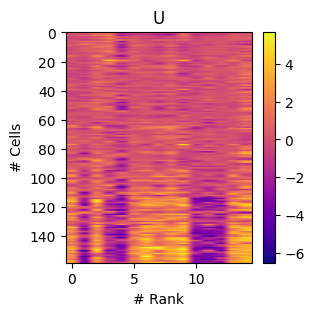

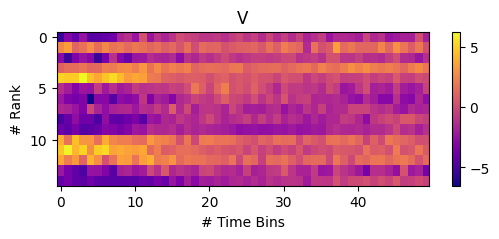

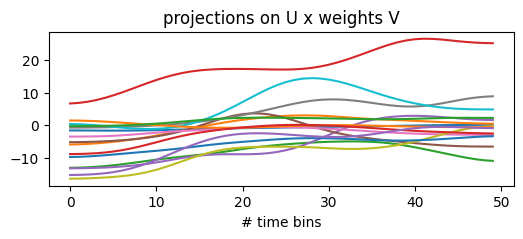

time-independent:
{'alpha': 100}
r2: 0.635 corr: 0.799
time-dependent:
{'alpha': 100}
r2: 0.716 corr: 0.882
{'alpha': 0.01}
sliding-window:
r2: 0.715 corr: 0.847


Train GLM:: 100%|███████████████████████████| 5000/5000 [03:32<00:00, 23.48it/s]


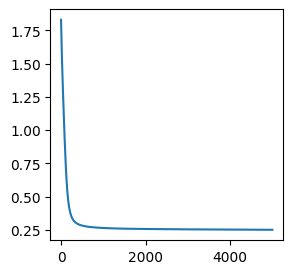

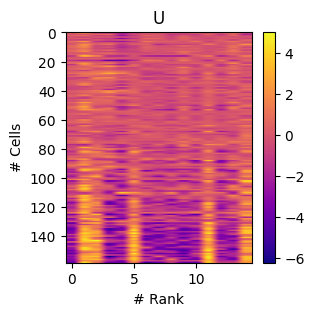

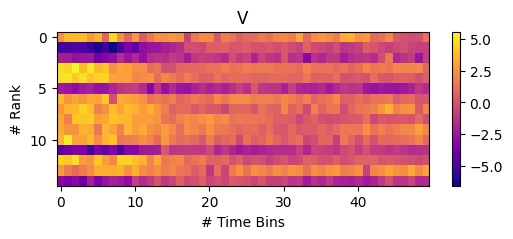

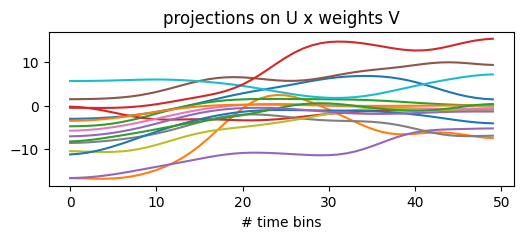

time-independent:
{'alpha': 100}
r2: 0.563 corr: 0.755
time-dependent:
{'alpha': 100}
r2: -0.271 corr: 0.848
{'alpha': 0.01}
sliding-window:
r2: 0.687 corr: 0.829


Train GLM:: 100%|███████████████████████████| 5000/5000 [03:34<00:00, 23.29it/s]


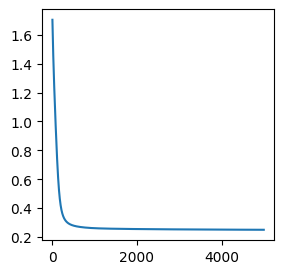

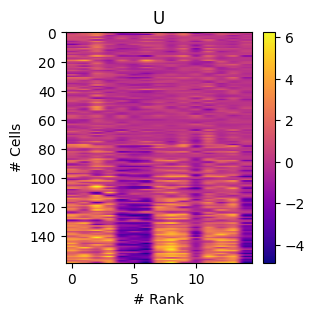

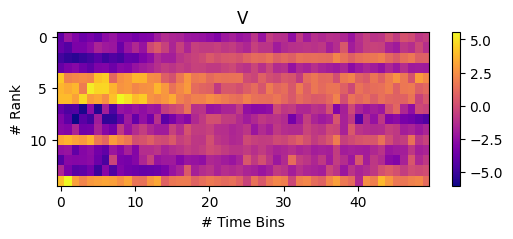

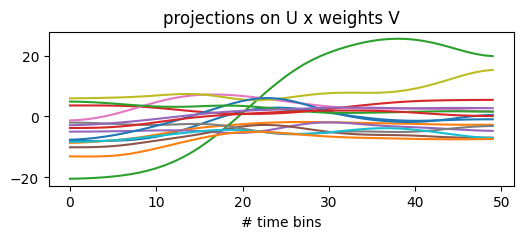

time-independent:
{'alpha': 100}
r2: 0.600 corr: 0.778
time-dependent:
{'alpha': 100}
r2: -0.567 corr: 0.853
{'alpha': 0.01}
sliding-window:
r2: 0.662 corr: 0.818


Train GLM:: 100%|███████████████████████████| 5000/5000 [03:36<00:00, 23.07it/s]


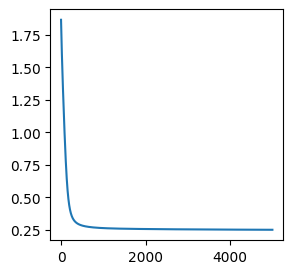

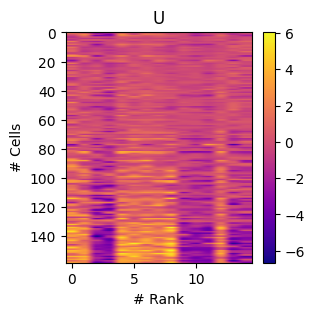

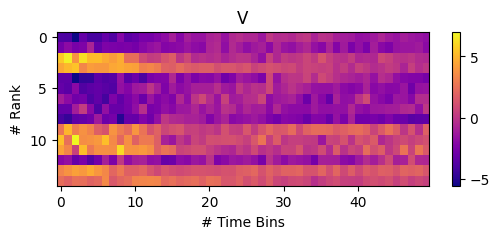

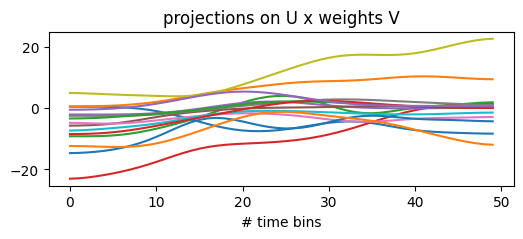

time-independent:
{'alpha': 100}
r2: 0.613 corr: 0.785
time-dependent:
{'alpha': 100}
r2: 0.241 corr: 0.870
{'alpha': 0.01}
sliding-window:
r2: 0.695 corr: 0.834


Train GLM:: 100%|███████████████████████████| 5000/5000 [03:41<00:00, 22.60it/s]


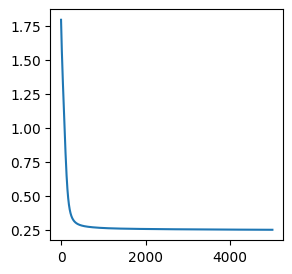

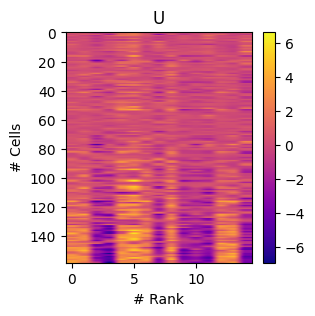

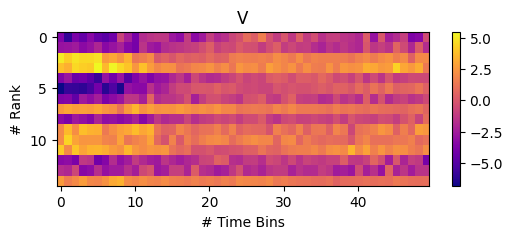

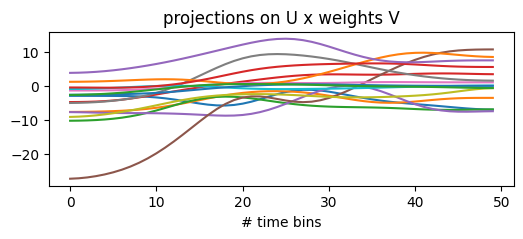

time-independent:
{'alpha': 100}
r2: 0.674 corr: 0.826
time-dependent:
{'alpha': 100}
r2: -0.563 corr: 0.885
{'alpha': 0.01}
sliding-window:
r2: 0.728 corr: 0.855
reduced-rank GLM:
time-independent r2: 0.6974224636844619 trial-wise r2: -0.08864896496555404


In [205]:
R = 15

obs_lst, pred_lst, r2_tbin, r2_trial = [], [], [], []
for fold_idx, (train, test) in enumerate(kf.split(X)):
    
    glm, losses = train_glm(
        X = smooth_X,
        Y = norm_Y, 
        train = train,
        test = test,
        n_r = R,
        learning_rate = 5e-3,
        n_epochs = 5000
    )
    
    plt.figure(figsize=(3,3))
    plt.plot(losses)
    
    supervised_subspace = glm.U.detach().numpy()
    subspace_weights = glm.V.detach().numpy()
    
    plt.figure(figsize=(3,3))
    plt.imshow(supervised_subspace, aspect="auto", cmap="plasma")
    plt.title("U")
    plt.xlabel("# Rank")
    plt.ylabel("# Cells")
    plt.colorbar()
    plt.show()
    
    plt.figure(figsize=(6,2))
    plt.imshow(subspace_weights, aspect="auto", cmap="plasma")
    plt.title("V")
    plt.xlabel("# Time Bins")
    plt.ylabel("# Rank")
    plt.colorbar()
    plt.show()
    
    all_proj = smooth_X.transpose(0,-1,1) @ supervised_subspace
    weighted_proj = all_proj * subspace_weights.T
    smooth_proj = np.array(
        [[gaussian_filter1d(weighted_proj[k, :, r], 4) for r in range(R)] for k in range(K)]
    )
    
    plt.figure(figsize=(6,2))
    plt.plot(smooth_proj.mean(0).T)
    plt.title("projections on U x weights V")
    plt.xlabel("# time bins")
    plt.show()
    
    train_X, test_X = smooth_proj[train], smooth_proj[test]
    train_Y, test_Y = norm_Y[train], norm_Y[test]

    _, _ = continuous_decoder(train_X, train_Y, test_X, test_Y, time_independent=True)
    _, metrics = continuous_decoder(train_X, train_Y, test_X, test_Y, time_independent=False)
    r2_trial.append(metrics[0])
    
    window_X = sliding_window_over_time(smooth_proj, half_window_size=5)
    window_Y = sliding_window_over_time(norm_Y, half_window_size=5)
    train_X, test_X = window_X[train], window_X[test]
    train_Y, test_Y = window_Y[train], window_Y[test]
    _, metrics = sliding_window_decoder(train_X, train_Y, test_X, test_Y)
    r2_tbin.append(metrics[0])
    
print("reduced-rank GLM:")
print(f"time-independent r2: {np.mean(r2_tbin)} trial-wise r2: {np.mean(r2_trial)}")

In [51]:
# smoothing 
wheel_speed = []
motion_energy = [0.645, 0.660]
pupil_diameter = []
paw_speed = []

In [52]:
smoothing_metrics = {
    "wheel_speed": wheel_speed,
    "motion_energy": motion_energy,
    "pupil_diameter": pupil_diameter,
    "paw_speed": paw_speed
}

In [53]:
# glm
wheel_speed = []
motion_energy = [0.697, ]
pupil_diameter = []
paw_speed = []

In [54]:
glm_metrics = {
    "wheel_speed": wheel_speed,
    "motion_energy": motion_energy,
    "pupil_diameter": pupil_diameter,
    "paw_speed": paw_speed
}

In [55]:
%matplotlib inline
plt.rc("figure", dpi=100)
SMALL_SIZE = 10
BIGGER_SIZE = 15
plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('axes', linewidth=1)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=BIGGER_SIZE-2)
plt.rc('figure', titlesize=2)
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.minor.size'] = 10
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.minor.size'] = 10

In [ ]:
fig, axes = plt.subplots(2,4, figsize=(16,6))
axes[0,0].plot(smoothing_metrics["wheel_speed"][0], c="k", linewidth=2, label="smoothing + ridge"); 
axes[0,1].plot(smoothing_metrics["motion_energy"][0], c="k", linewidth=2); 
axes[0,2].plot(smoothing_metrics["pupil_diameter"][0], c="k", linewidth=2); 
axes[0,3].plot(smoothing_metrics["paw_speed"][0], c="k", linewidth=2);

axes[0,0].plot(glm_metrics["wheel_speed"][0], c="b", linewidth=2, label="latents + ridge"); 
axes[0,1].plot(glm_metrics["motion_energy"][0], c="b", linewidth=2); 
axes[0,2].plot(glm_metrics["pupil_diameter"][0], c="b", linewidth=2); 
axes[0,3].plot(glm_metrics["paw_speed"][0], c="b", linewidth=2);

axes[1,0].plot(smoothing_metrics["wheel_speed"][1], c="k", linewidth=2, label="smoothing + ridge"); 
axes[1,1].plot(smoothing_metrics["motion_energy"][1], c="k", linewidth=2); 
axes[1,2].plot(smoothing_metrics["pupil_diameter"][1], c="k", linewidth=2); 
axes[1,3].plot(smoothing_metrics["paw_speed"][1], c="k", linewidth=2);

axes[1,0].plot(glm_metrics["wheel_speed"][1], c="b", linewidth=2, label="latents + ridge"); 
axes[1,1].plot(glm_metrics["motion_energy"][1], c="b", linewidth=2); 
axes[1,2].plot(glm_metrics["pupil_diameter"][1], c="b", linewidth=2); 
axes[1,3].plot(glm_metrics["paw_speed"][1], c="b", linewidth=2);

axes[0,0].set_ylabel(r"$R^2$")
axes[1,0].set_ylabel("corr")

behavior_type = ["wheel speed", "motion energy", "pupil diameter", "paw speed"]
for i in range(2):
    for j in range(4):
        axes[0,j].set_title(behavior_type[j])
        axes[0,j].set_ylim(0.2, 0.7)
        axes[1,j].set_ylim(0.4, 0.9)
        axes[i,j].set_xticks(np.arange(5), ["po", "lp", "dg", "ca1", "vis"])

axes[0,0].legend(frameon=False)

plt.tight_layout()
# plt.savefig("continuous_perf_eval.png", dpi=100)